In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/MyDrive/ENGG680_ML_Project/

/content/drive/MyDrive/ENGG680_ML_Project


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve

In [9]:
#trying to use the combined csv's to do the split to see if the combined dataset works any better
# Load pre-paired CSVs (these guarantee diversity: 0, 1, 2, 3)
df_0 = pd.read_csv("Combined_Datasets_CSV/combined_open_eye_no_yawn.csv")
df_1 = pd.read_csv("Combined_Datasets_CSV/combined_open_eye_yawn.csv")
df_2 = pd.read_csv("Combined_Datasets_CSV/combined_closed_eye_no_yawn.csv")
df_3 = pd.read_csv("Combined_Datasets_CSV/combined_closed_eye_yawn.csv")


# Combine all
full_df = pd.concat([df_0, df_1, df_2, df_3], ignore_index=True)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train/test
train_df, test_df = train_test_split(
    full_df,
    test_size=0.2, # train size = 80% and test size = 20%
    stratify=full_df['label'],  # Maintains 0, 1, 2, 3 distribution
    random_state=42 # for reproducibility
)

print("Train label distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df['label'].value_counts().sort_index())

#size for all images
image_resize = (128, 128)

def load_from_combined(df):
    X_eye, X_mouth, y, eye_files, mouth_files = [], [], [], [], []
    expected_h = image_resize[0]
    expected_w = image_resize[1] * 2  # combined width

    for _, row in df.iterrows():
        img = cv2.imread(row['combined_image_path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # cv2 returns shape (h, w) for grayscale
        if img.shape != (expected_h, expected_w):
            # only resize if size differs (cv2.resize takes (w,h))
            img = cv2.resize(img, (expected_w, expected_h))

        left = img[:, :image_resize[1]]
        right = img[:, image_resize[1]:]

        X_eye.append(np.expand_dims(left.astype('float32') / 255.0, -1))
        X_mouth.append(np.expand_dims(right.astype('float32') / 255.0, -1))
        y.append(int(row['label']))
        eye_files.append(os.path.basename(row['combined_image_path']) + '_L')
        mouth_files.append(os.path.basename(row['combined_image_path']) + '_R')
    return np.array(X_eye), np.array(X_mouth), np.array(y), np.array(eye_files), np.array(mouth_files)

X_eye_train, X_mouth_train, y_train, eye_files_train, mouth_files_train = load_from_combined(train_df)
X_eye_test,  X_mouth_test,  y_test,  eye_files_test,  mouth_files_test  = load_from_combined(test_df)

# create binary labels for separate models
# label mapping: 0=open,no_yawn | 1=open,yawn | 2=closed,no_yawn | 3=closed,yawn
# eye: 0=open (labels 0,1) -> 0 ; 1=closed (labels 2,3) -> 1
y_eye_train  = (y_train >= 2).astype(int)
y_eye_test   = (y_test  >= 2).astype(int)

# mouth: 0=no_yawn (labels 0,2) -> 0 ; 1=yawn (labels 1,3) -> 1
y_mouth_train = (y_train % 2 == 1).astype(int)
y_mouth_test  = (y_test  % 2 == 1).astype(int)

# quick sanity prints
print("Train shapes:", X_eye_train.shape, X_mouth_train.shape, y_train.shape)
print("Binary label counts (eye,mouth):",
      np.bincount(y_eye_train), np.bincount(y_mouth_train))

Train label distribution:
label
0    160
1    160
2    160
3    160
Name: count, dtype: int64

Test label distribution:
label
0    40
1    40
2    40
3    40
Name: count, dtype: int64
Train shapes: (640, 128, 128, 1) (640, 128, 128, 1) (640,)
Binary label counts (eye,mouth): [320 320] [320 320]


In [10]:
#model architecture for eye state classification
def build_eye_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

eye_model = build_eye_cnn()

history_eye = eye_model.fit(
    X_eye_train, y_eye_train,
    validation_data=(X_eye_test, y_eye_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4722 - loss: 0.7170 - val_accuracy: 0.5000 - val_loss: 0.6749
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6108 - loss: 0.6346 - val_accuracy: 0.8813 - val_loss: 0.4051
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8994 - loss: 0.3486 - val_accuracy: 0.9688 - val_loss: 0.1224
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9797 - loss: 0.0930 - val_accuracy: 0.9937 - val_loss: 0.0330
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9935 - loss: 0.0240 - val_accuracy: 1.0000 - val_loss: 0.0137


In [11]:
#model architecture for mouth state classification
def build_mouth_cnn():
    model = models.Sequential([

        # Input shape: 128x128 grayscale
        layers.Input(shape=(128, 128, 1)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),     # Prevent overfitting
        layers.Dense(1, activation='sigmoid') #output layer
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

mouth_model = build_mouth_cnn()

history_mouth = mouth_model.fit(
    X_mouth_train, y_mouth_train,
    validation_data=(X_mouth_test, y_mouth_test),
    epochs=5,
    batch_size=32)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5518 - loss: 0.7297 - val_accuracy: 0.8750 - val_loss: 0.3581
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8313 - loss: 0.3618 - val_accuracy: 0.9125 - val_loss: 0.2266
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9009 - loss: 0.2531 - val_accuracy: 0.9375 - val_loss: 0.1749
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9403 - loss: 0.1731 - val_accuracy: 0.9438 - val_loss: 0.1581
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9496 - loss: 0.1477 - val_accuracy: 0.9688 - val_loss: 0.1492


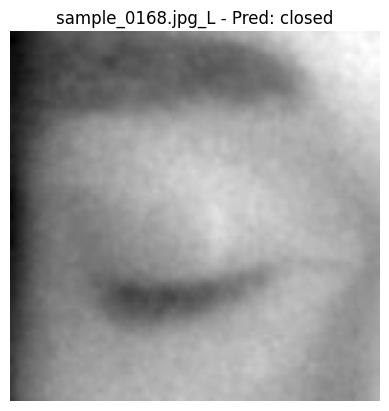

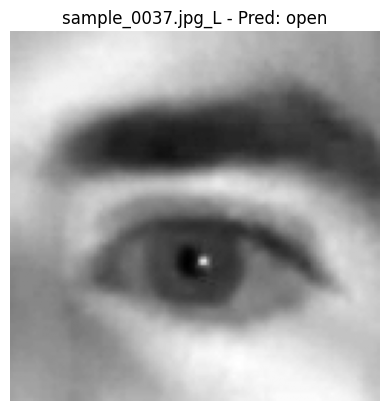

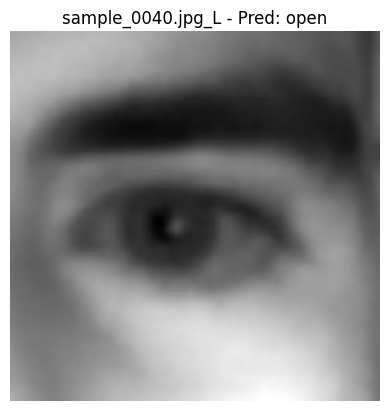

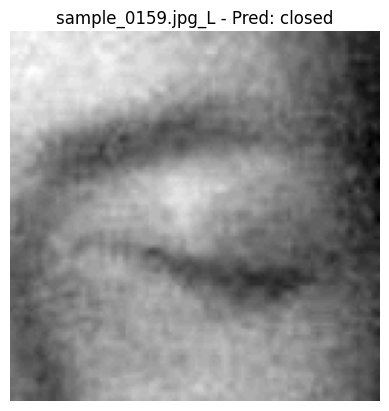

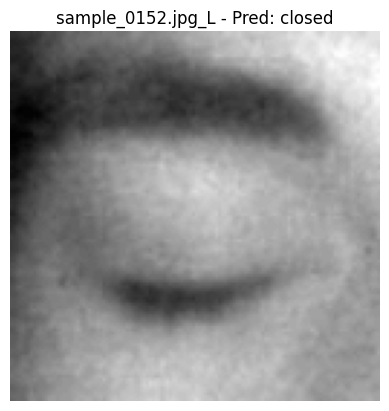

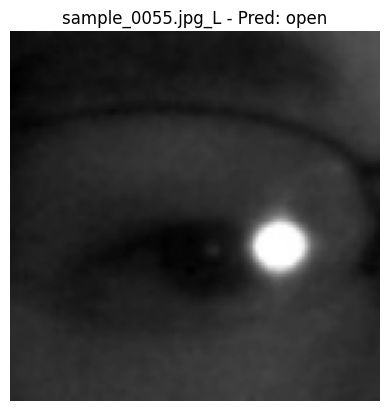

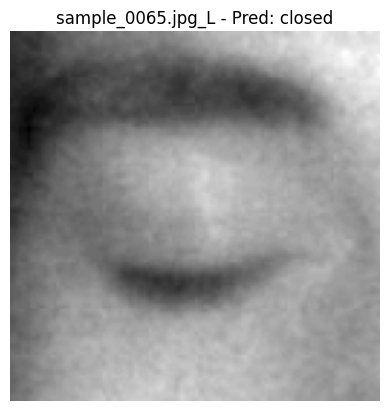

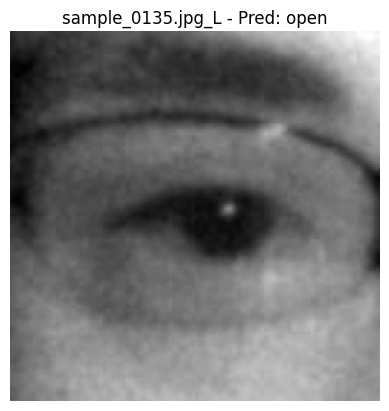

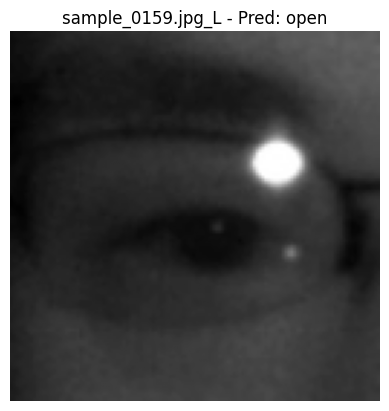

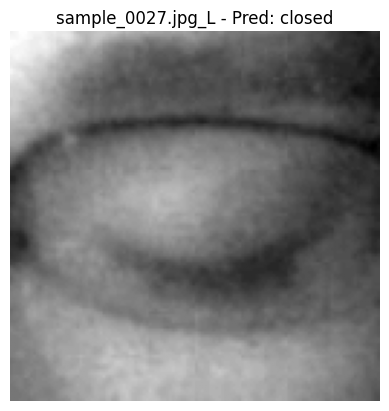

In [12]:
#looking to see how the eye test images are being classified by theeye state detection model
# 0 = open, 1 = closed
import matplotlib.pyplot as plt

for i in range(10):   # show first 10
    prob_closed = eye_model.predict(np.array([X_eye_test[i]]), verbose=0)[0][0]
    pred = 1 if prob_closed >= 0.5 else 0

    plt.imshow(X_eye_test[i].squeeze(), cmap='gray')
    plt.title(f"{eye_files_test[i]} - Pred: {'closed' if pred==1 else 'open'}")
    plt.axis('off')
    plt.show()

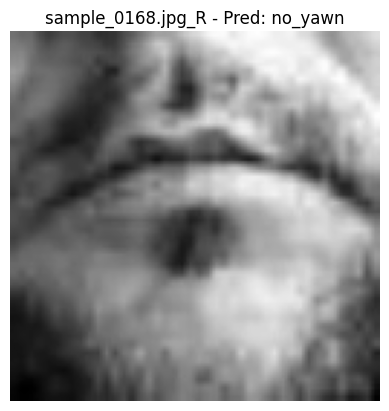

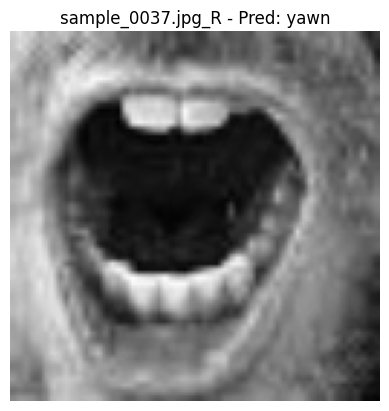

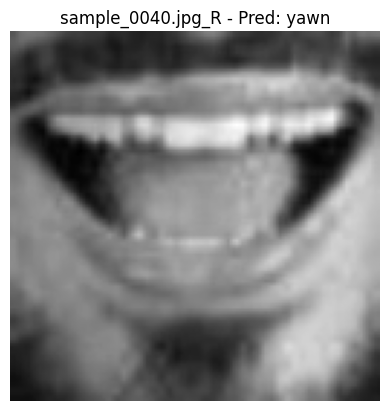

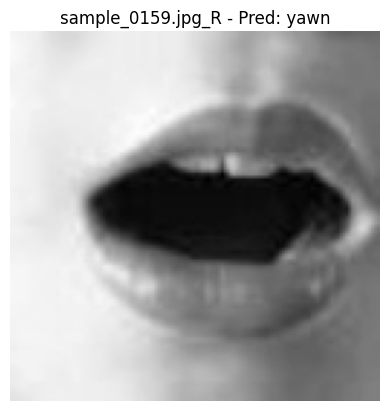

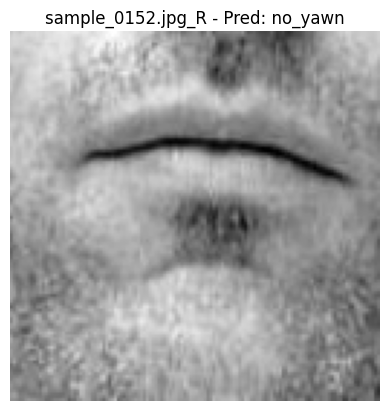

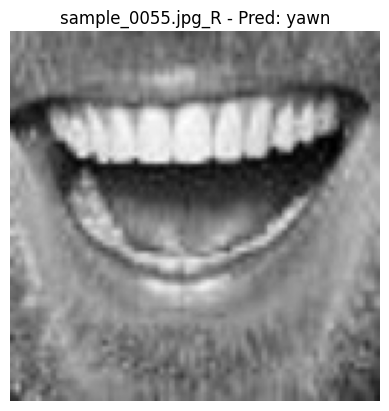

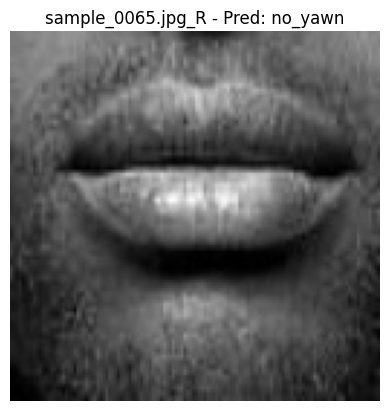

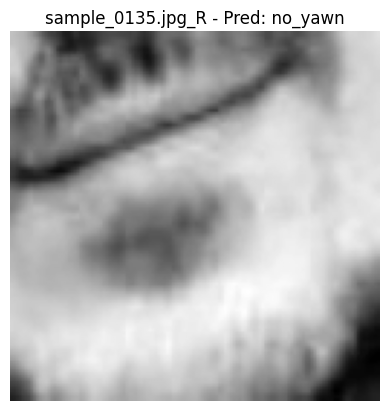

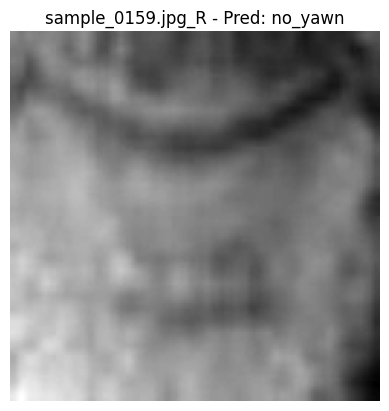

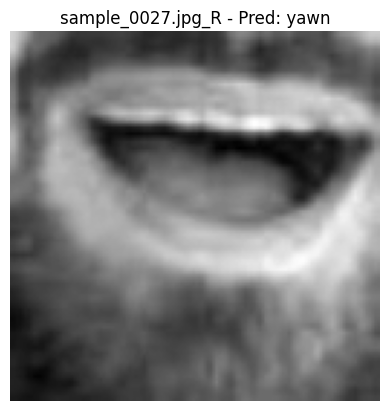

In [13]:
# looking to see how the test mouth images are being classified by the mouth state detection model
# 0 = no yawn, 1 = yawn


import matplotlib.pyplot as plt

for i in range(10):   # show first 10
    prob_open = mouth_model.predict(np.array([X_mouth_test[i]]), verbose=0)[0][0]
    pred = 1 if prob_open >= 0.5 else 0 # 0 - no yawn, 1 - yawn

    plt.imshow(X_mouth_test[i].squeeze(), cmap='gray')
    plt.title(f"{mouth_files_test[i]} - Pred: {'yawn' if pred==1 else 'no_yawn'}")
    plt.axis('off')
    plt.show()

In [14]:
#model architecture for mapping outputs to their final classes and the corresponding messages

def combine_hard_labels(eye_model, mouth_model, eye_img, mouth_img):

    # Predict raw probabilities
    p_eye_closed = eye_model.predict(np.array([eye_img]), verbose=0)[0][0] #probability eyes = closed
    p_mouth_open = mouth_model.predict(np.array([mouth_img]), verbose=0)[0][0] #probability mouth = open

    # Convert to binary labels
    eye_label = 1 if p_eye_closed >= 0.5 else 0 #1 = closed, 0 = open
    mouth_label = 1 if p_mouth_open >= 0.5 else 0 #1 = yawn, 0 = no yawn

    # Correct class mapping based on your definition
    if eye_label == 0 and mouth_label == 0:
        final_class = 0  # eyes open mouth closed
    elif eye_label == 0 and mouth_label == 1:
        final_class = 1 # eyes open mouth open
    elif eye_label == 1 and mouth_label == 0:
        final_class = 2 # eyes closed mouth closed
    elif eye_label == 1 and mouth_label == 1:
        final_class = 3 # eyes closed mouth open

    # Label dictionary
    labels = {
        0: "eyes_open__mouth_closed",
        1: "eyes_open__yawning",
        2: "eyes_closed__mouth_closed",
        3: "eyes_closed__yawning"
    }

    # message dictionary for the classes
    messages = {
        0: "Good job, you are alert!",
        1: "Getting sleepy there? Consider taking a break.",
        2: "🚨 ALERT ALERT 🚨",
        3: "That was a big yawn, take a break!"
    }

    #print the messages
    print(messages[final_class])

    return final_class, labels[final_class]

In [15]:
# storing the outputs from the mapping function

combined_pred = []

for i in range(len(X_eye_test)):
    final_class, final_label = combine_hard_labels(
        eye_model,
        mouth_model,
        X_eye_test[i],      # <--- numpy array
        X_mouth_test[i]     # <--- numpy array
    )

    combined_pred.append({
        "eye_file": eye_files_test[i],
        "mouth_file": mouth_files_test[i],
        "predicted_class": final_class,
        "predicted_label": final_label
    })

🚨 ALERT ALERT 🚨
Getting sleepy there? Consider taking a break.
Getting sleepy there? Consider taking a break.
That was a big yawn, take a break!
🚨 ALERT ALERT 🚨
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
Good job, you are alert!
Good job, you are alert!
That was a big yawn, take a break!
Good job, you are alert!
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
Good job, you are alert!
Good job, you are alert!
Good job, you are alert!
Good job, you are alert!
🚨 ALERT ALERT 🚨
Good job, you are alert!
That was a big yawn, take a break!
🚨 ALERT ALERT 🚨
🚨 ALERT ALERT 🚨
Good job, you are alert!
🚨 ALERT ALERT 🚨
Good job, you are alert!
That was a big yawn, take a break!
Good job, you are alert!
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
Good job, you are alert!
Getting sleepy there? Consider taking a break.
🚨 ALERT ALERT 🚨
🚨 ALERT ALERT 🚨
Good job, you are alert!
🚨 ALERT ALERT 🚨
Good job, you are alert!
Getting sleepy there? Consider takin

That was a big yawn, take a break!


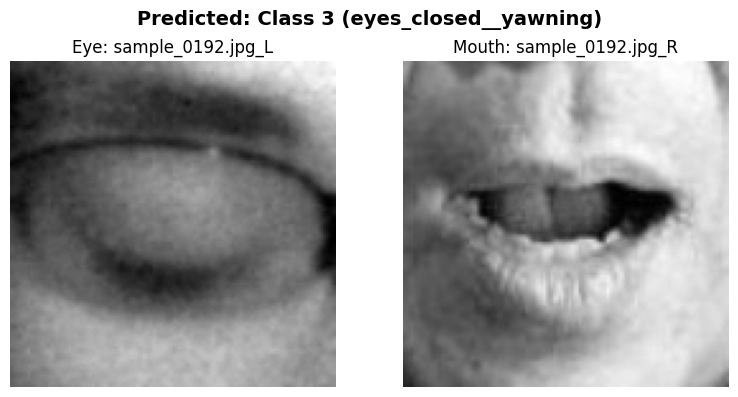

Ground Truth - Eye label: 1, Mouth label: 1


In [16]:
# using a random eye mouth pairing to test the combined model

import random

# Pick a random index
random_idx = random.randint(0, len(X_eye_test) - 1)

# Get random eye and mouth
random_eye = X_eye_test[random_idx]
random_mouth = X_mouth_test[random_idx]
random_eye_file = eye_files_test[random_idx]
random_mouth_file = mouth_files_test[random_idx]

# Get predictions
final_class, final_label = combine_hard_labels(
    eye_model, mouth_model,
    random_eye, random_mouth
)

#display the results of the random pairing
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(random_eye.squeeze(), cmap='gray')
axes[0].set_title(f"Eye: {random_eye_file}")
axes[0].axis('off')

axes[1].imshow(random_mouth.squeeze(), cmap='gray')
axes[1].set_title(f"Mouth: {random_mouth_file}")
axes[1].axis('off')

fig.suptitle(f"Predicted: Class {final_class} ({final_label})", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print ground truth for comparison
print(f"Ground Truth - Eye label: {y_eye_test[random_idx]}, Mouth label: {y_mouth_test[random_idx]}")

In [18]:
#metrics for test data eyes
y_prob_eye = eye_model.predict(X_eye_test).ravel()

# Convert probability → class prediction (threshold = 0.5)
y_pred_eye = (y_prob_eye >= 0.5).astype(int)

acc = accuracy_score(y_eye_test, y_pred_eye)
rec = recall_score(y_eye_test, y_pred_eye, zero_division=0)
f1 = f1_score(y_eye_test, y_pred_eye, zero_division=0)
roc_auc = roc_auc_score(y_eye_test, y_prob_eye)
pr_auc = average_precision_score(y_eye_test, y_prob_eye)

# FNR = FN / (FN + TP)
tn, fp, fn, tp = confusion_matrix(y_eye_test, y_pred_eye).ravel()
fnr = fn / (fn + tp)

# print test metrics
print("\nTest Metrics:")
print(f"Accuracy : {acc:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc_auc:.3f}")
print(f"PR_AUC   : {pr_auc:.3f}")
print(f"FNR      : {fnr:.3f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step

Test Metrics:
Accuracy : 1.000
Recall   : 1.000
F1-score : 1.000
ROC-AUC  : 1.000
PR_AUC   : 1.000
FNR      : 0.000


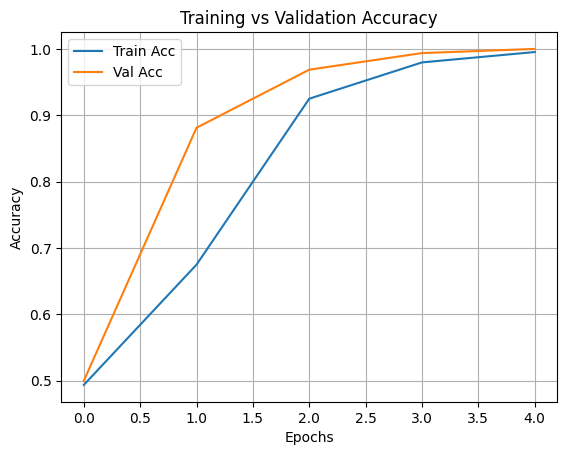

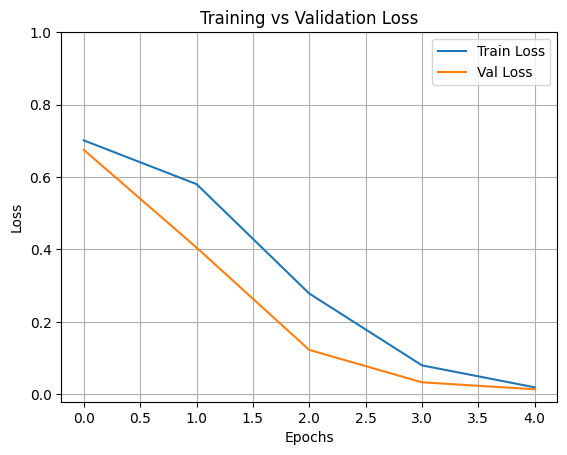

In [19]:
plt.plot(history_eye.history["accuracy"], label="Train Acc")
plt.plot(history_eye.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid()
plt.legend()
plt.show()

plt.plot(history_eye.history["loss"], label="Train Loss")
plt.plot(history_eye.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid()
plt.legend()
plt.ylim(top=1.0)
plt.show()

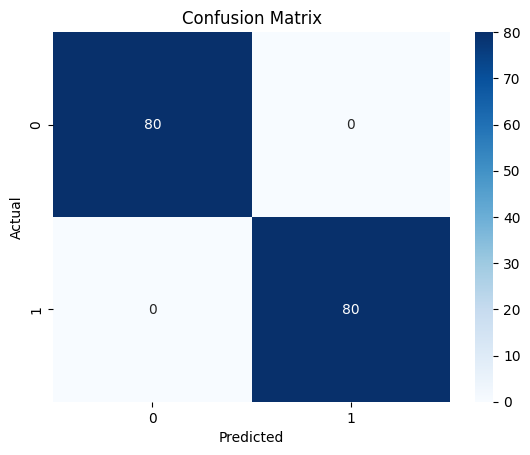

In [20]:
import seaborn as sns

#confusion matrix heat map

cm_eye = confusion_matrix(y_eye_test, y_pred_eye)
sns.heatmap(cm_eye, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
#dispalying mispredicted images

mis_idx = np.where(y_pred_eye != y_eye_test)[0]
print("Misclassified samples:", len(mis_idx))

#loop through wrongly labelled images to show all of them
for i in mis_idx:
    plt.imshow(X_eye_test[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_eye_test[i]}, Predicted: {y_pred_eye[i]}, Prob: {y_prob_eye[i]:.2f}")
    plt.axis('off')
    plt.show()

Misclassified samples: 0


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(10, 128, 128, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 128, 128, 1))']
  warnings.warn(msg)


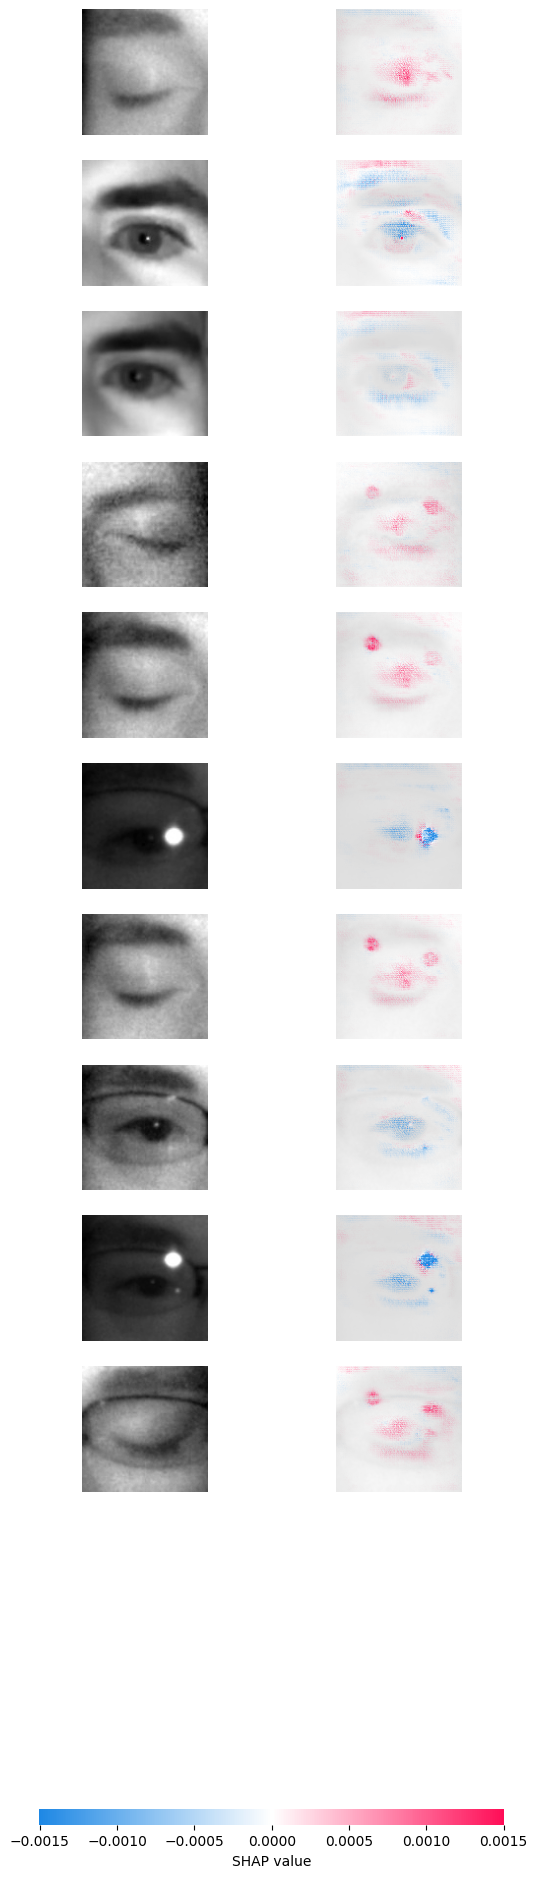

In [22]:
import shap

#shap explainer for explainable AI

background = X_eye_train[np.random.choice(X_eye_train.shape[0], 100, replace=False)]
explainer = shap.GradientExplainer(eye_model, background)

shap_values = explainer.shap_values(X_eye_test[:10])
shap.image_plot(shap_values, X_eye_test[:10])

In [23]:
#metrics for test data - mouth
y_prob_mouth = mouth_model.predict(X_mouth_test).ravel()

# Convert probability → class prediction (threshold = 0.5)
y_pred_mouth = (y_prob_mouth >= 0.5).astype(int)

acc = accuracy_score(y_mouth_test, y_pred_mouth)
rec = recall_score(y_mouth_test, y_pred_mouth, zero_division=0)
f1 = f1_score(y_mouth_test, y_pred_mouth, zero_division=0)
roc_auc = roc_auc_score(y_mouth_test, y_prob_mouth)
pr_auc = average_precision_score(y_mouth_test, y_prob_mouth)

# FNR = FN / (FN + TP)
tn, fp, fn, tp = confusion_matrix(y_mouth_test, y_pred_mouth).ravel()
fnr = fn / (fn + tp)

# print test metrics
print("\nTest Metrics:")
print(f"Accuracy : {acc:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc_auc:.3f}")
print(f"PR_AUC   : {pr_auc:.3f}")
print(f"FNR      : {fnr:.3f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step

Test Metrics:
Accuracy : 0.969
Recall   : 0.938
F1-score : 0.968
ROC-AUC  : 0.981
PR_AUC   : 0.986
FNR      : 0.062


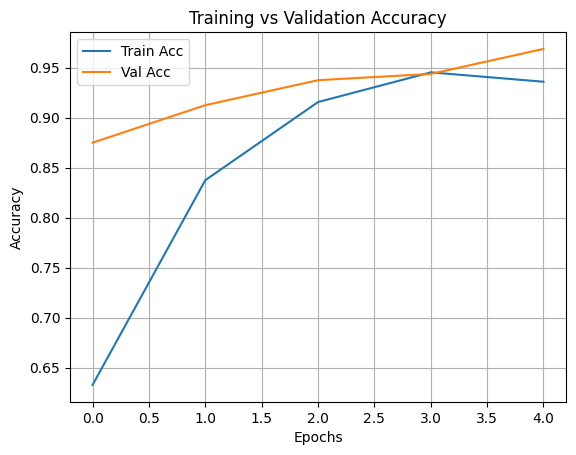

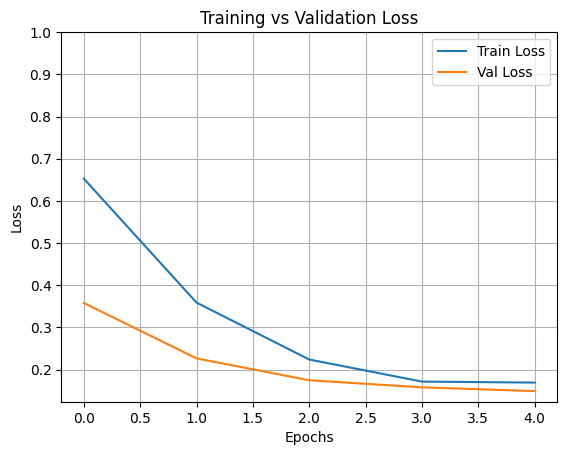

In [24]:
plt.plot(history_mouth.history["accuracy"], label="Train Acc")
plt.plot(history_mouth.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(history_mouth.history["loss"], label="Train Loss")
plt.plot(history_mouth.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(top=1.0)
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


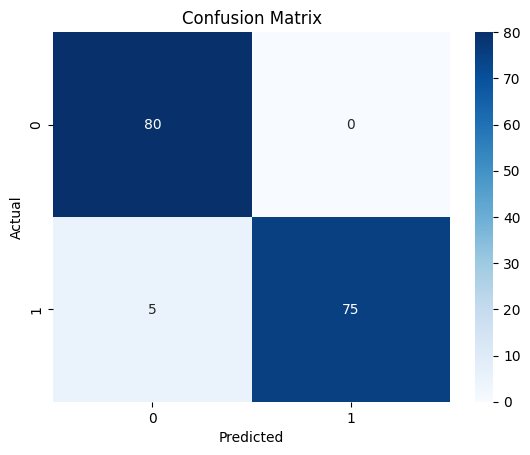

In [25]:
#confusion matrix heat map

cm_mouth = confusion_matrix(y_mouth_test, y_pred_mouth)
sns.heatmap(cm_mouth, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Misclassified samples: 5


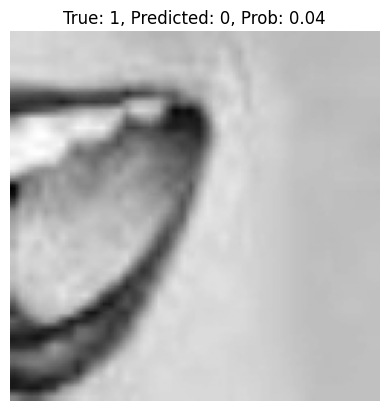

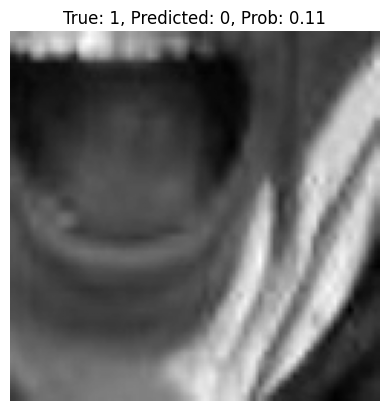

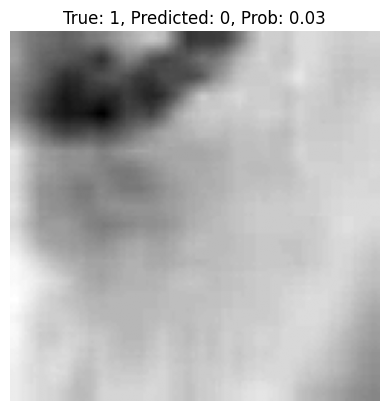

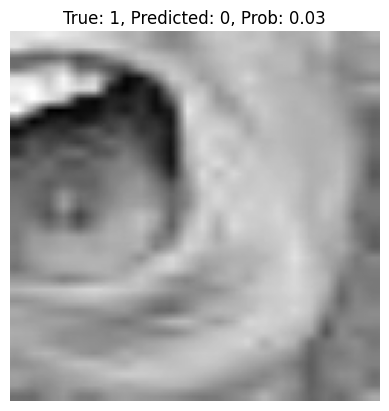

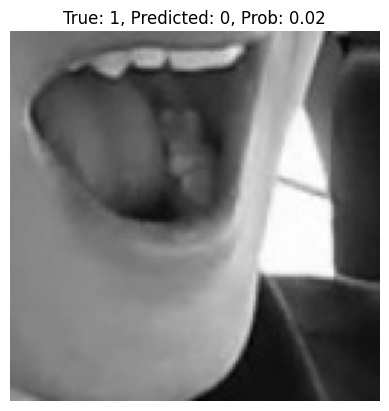

In [26]:
#dispalying mispredicted images

mis_idx = np.where(y_pred_mouth != y_mouth_test)[0]
print("Misclassified samples:", len(mis_idx))

#loop through wrongly labelled images to show all of them
for i in mis_idx:
    plt.imshow(X_mouth_test[i].squeeze(), cmap='gray')
    plt.title(f"True: {y_mouth_test[i]}, Predicted: {y_pred_mouth[i]}, Prob: {y_prob_mouth[i]:.2f}")
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(10, 128, 128, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(50, 128, 128, 1))']
  warnings.warn(msg)


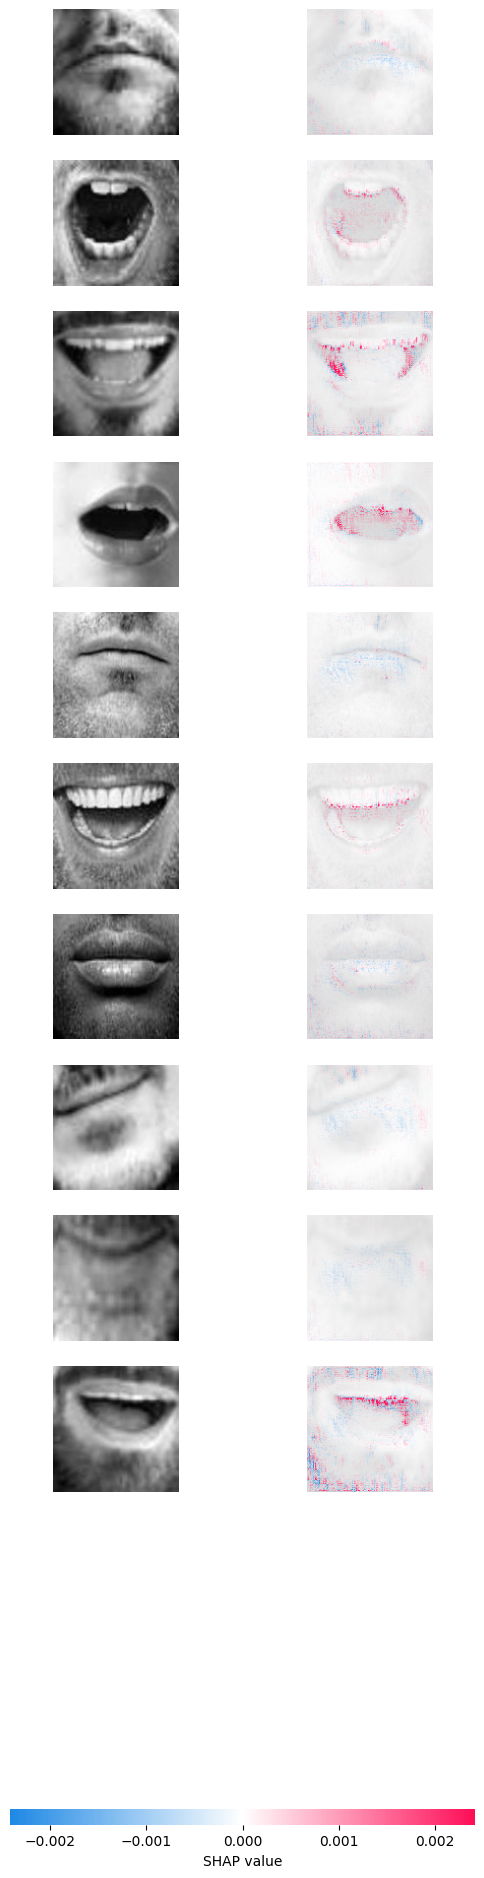

In [27]:
#shap explainer for explainable AI

background = X_mouth_train[np.random.choice(X_mouth_train.shape[0], 100, replace=False)]
explainer = shap.GradientExplainer(mouth_model, background)

shap_values = explainer.shap_values(X_mouth_test[:10])
shap.image_plot(shap_values, X_mouth_test[:10])
